In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
import seaborn as sns
import statsmodels.api as sm
from sklearn.tree import export_graphviz
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
import graphviz
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
best_X = pd.read_pickle('best_X.pkl')
good_X = pd.read_pickle('good_X.pk2')
all_X = pd.read_pickle('all_X.pk3')
scaled_y = pd.read_pickle('scaled_y.pk4')

FileNotFoundError: [Errno 2] No such file or directory: 'good_X.pk2'

#### Using all_X (all features)

{'learning_rate': 0.5, 'n_estimators': 100}
GridSearchSV Score: 0.46808510638297873


c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

         0.0       0.56      0.96      0.70        46
         1.0       0.32      0.35      0.34        60
         2.0       0.83      0.15      0.26        65
         3.0       0.38      0.60      0.47        53
         4.0       0.60      0.40      0.48        63
         5.0       0.00      0.00      0.00        69
         6.0       0.47      0.99      0.63        67

    accuracy                           0.47       423
   macro avg       0.45      0.49      0.41       423
weighted avg       0.44      0.47      0.39       423

Accuracy:  0.46808510638297873


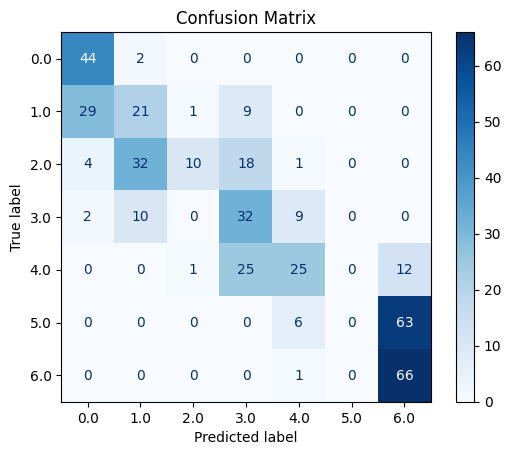

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(all_X, scaled_y, test_size = 0.2, random_state=1234)

# hyperparameter tuning with GridSearchCv
params = {'n_estimators': [10, 50, 100],
          'learning_rate': [0.01, 0.1, 0.5]
          }

grid = GridSearchCV(AdaBoostClassifier(algorithm='SAMME'), params, cv=10, scoring='accuracy', return_train_score=False)
grid = grid.fit(X_train, np.ravel(y_train))

print(grid.best_params_)
print('GridSearchSV Score:', grid.score(X_test, y_test))

# plug in the best hyperparameters determined above
ada_dt_all = AdaBoostClassifier(algorithm='SAMME', n_estimators=100, learning_rate=0.5)

ada_dt_all = ada_dt_all.fit(X_train, np.ravel(y_train))

y_pred = ada_dt_all.predict(X_test)
y_pred_probas = ada_dt_all.predict_proba(X_test)

print(classification_report(y_test, y_pred)) # assumes 0.5 threshold as default
print('Accuracy: ', accuracy_score(y_test, y_pred))

cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=ada_dt_all.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# visualize tree
dot_data = export_graphviz(
    ada_dt_all,
    out_file=None,
    feature_names=list(X_train.columns),
    class_names=[str(c) for c in ada_dt_all.classes_],
    filled=True, rounded=True,
    special_characters=True
)

graph = graphviz.Source(dot_data)
graph

# ROC Curve

# Precision-Recall Curve

NameError: name 'tree' is not defined

#### Using best_X (best features)

{'learning_rate': 0.5, 'n_estimators': 100}
GridSearchSV Score: 0.46808510638297873
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        46
         1.0       0.00      0.00      0.00        60
         2.0       0.00      0.00      0.00        65
         3.0       0.19      1.00      0.32        53
         4.0       0.00      0.00      0.00        63
         5.0       0.00      0.00      0.00        69
         6.0       0.45      1.00      0.62        67

    accuracy                           0.28       423
   macro avg       0.09      0.29      0.14       423
weighted avg       0.10      0.28      0.14       423

Accuracy:  0.28368794326241137


c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


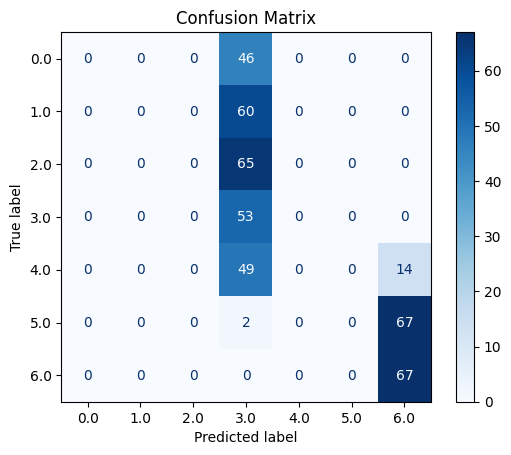

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(best_X, scaled_y, test_size = 0.2, random_state=1234)

# hyperparameter tuning with GridSearchCv
params = {'n_estimators': [10, 50, 100],
          'learning_rate': [0.01, 0.1, 0.5]
          }

grid = GridSearchCV(AdaBoostClassifier(algorithm='SAMME'), params, cv=10, scoring='accuracy', return_train_score=False)
grid = grid.fit(X_train, np.ravel(y_train))

print(grid.best_params_)
print('GridSearchSV Score:', grid.score(X_test, y_test))

# plug in the best hyperparameters determined above
ada_dt_best = AdaBoostClassifier(algorithm='SAMME', n_estimators=100, learning_rate=0.5)

ada_dt_best = ada_dt_best.fit(X_train, np.ravel(y_train))

y_pred = ada_dt_best.predict(X_test)
y_pred_probas = ada_dt_best.predict_proba(X_test)

print(classification_report(y_test, y_pred)) # assumes 0.5 threshold as default
print('Accuracy: ', accuracy_score(y_test, y_pred))

cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=ada_dt_best.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# visualize tree
dot_data = export_graphviz(
    ada_dt_best,
    out_file=None,
    feature_names=list(X_train.columns),
    class_names=[str(c) for c in ada_dt_best.classes_],
    filled=True, rounded=True,
    special_characters=True
)

graph = graphviz.Source(dot_data)
graph

# ROC Curve

# Precision-Recall Curve